In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib as mpl
import scipy
import warnings
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
sns.set_style("white")
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.stats import pearsonr
from sklearn.model_selection import KFold


In [2]:
import pandas as pd, numpy as np, pickle
df=pd.read_csv('data/SAdata_eyeTrackingOnly.csv') 
Xall,yall=df.iloc[:,:-1],df.iloc[:,-1]

In [3]:
df

,numS,sAmpMean,sAmpStd,sAmpMax,numF,fMean,fStd,fMax,backMirror,leftMirror,rightMirror,road,sky,pupilChange,pupilMean,pupilStd,SA
0,32,441.043606,352.958168,1404.201154,32,338.234375,150.139021,874.5,0,5,3,24,0,0.733955,3.818149,0.169227,0.641219
1,16,438.235768,407.423520,1341.926097,16,331.187500,259.331633,1014.0,2,2,1,9,2,0.623622,3.743575,0.178412,0.354868
2,3,134.665553,40.900834,180.282348,3,234.000000,28.022313,259.5,0,0,0,3,0,0.205836,3.326857,0.079828,0.561225
3,7,304.512096,304.615955,787.998511,7,396.214286,126.844017,636.0,0,1,0,6,0,0.020505,3.643468,0.034005,0.422067
4,23,380.870271,308.996408,1083.611274,23,350.391304,196.492942,807.0,5,4,1,13,0,0.632357,3.669544,0.196699,0.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,2,403.760234,7.586177,409.124471,2,556.500000,271.529004,748.5,1,0,0,1,0,0.342905,2.722796,0.116738,0.319177
1052,14,355.538620,284.262025,973.813757,14,391.714286,377.619656,1365.0,5,1,0,8,0,0.486911,2.799394,0.122229,0.246157
1053,22,281.581594,275.973327,1020.012718,22,480.750000,447.928320,1756.0,5,2,0,15,0,0.405155,2.826210,0.118613,0.055587
1054,1,272.956863,232.091951,639.348547,1,1026.000000,0.000000,1026.0,0,0,0,1,0,0.174587,2.480916,0.078884,0.218539


In [6]:
from datetime import datetime
import lightgbm as lgb

# specify your configurations as a dict
params = {
    'boosting_type': 'goss',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 100,
    'learning_rate': 0.05,
   # 'feature_fraction': 0.9,
   # 'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'feature_pre_filter': False
}

X = np.array(Xall)
Y = np.array(yall)
Y = 1 - Y;
rmse_v = []
mae_v = []
Corr_v = []
Xdata = []
shap_values = []

startTime = datetime.now()
count = 0;
skf = KFold(n_splits=10, shuffle=True, random_state=0)
for train_index, test_index in skf.split(X,Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    Xdata.append(X_test)

    count = count + 1
    print(count)
    d_train = lgb.Dataset(X_train, y_train)
    d_valid = lgb.Dataset(X_test, y_test)

    model = lgb.train(params, d_train, 5000, valid_sets=[d_valid], verbose_eval=False, early_stopping_rounds=100)
    y_pred = model.predict(X_test)
            
    rmse_v.append(np.sqrt(mean_squared_error(y_test, y_pred)))     
    mae_v.append(mean_absolute_error(y_test, y_pred))    
    Corr_v.append(np.corrcoef(y_test,y_pred))

    explainer = shap.TreeExplainer(model, X_train)
    shap_values.append(explainer.shap_values(X_test))
    print(datetime.now()-startTime)
print(np.mean(rmse_v))
print(np.mean(mae_v))
print(np.mean(Corr_v))

1
0:00:00.312864
2
0:00:00.627331
3
0:00:01.061617
4
0:00:01.869697
5
0:00:02.795849
6
0:00:03.432301
7
0:00:04.118494
8
0:00:04.317495
9
0:00:04.855280
10
0:00:05.136699
0.12161932759307706
0.09639578172805702
0.7157877427038063


In [7]:
print(np.mean(rmse_v))
print(np.mean(mae_v))
print(np.mean(Corr_v))
print(np.std(rmse_v))
print(np.std(mae_v))
print(np.std(Corr_v))

0.12161932759307706
0.09639578172805702
0.7157877427038063
0.008072550073901662
0.006883655737806818
0.288692007656534


In [8]:
df.columns

Index(['numS', 'sAmpMean', 'sAmpStd', 'sAmpMax', 'numF', 'fMean', 'fStd',
       'fMax', 'backMirror', 'leftMirror', 'rightMirror', 'road', 'sky',
       'pupilChange', 'pupilMean', 'pupilStd', 'SA'],
      dtype='object')

In [9]:
Xdata = np.array(Xdata)
Xdata.shape
Y = np.concatenate((Xdata[0], Xdata[1],Xdata[2],Xdata[3],Xdata[4],Xdata[5],Xdata[6],Xdata[7],Xdata[8],Xdata[9]), axis=0)
Y.shape
shap_values = np.array(shap_values)
shap_values.shape
SHAP = np.concatenate((shap_values[0], shap_values[1],shap_values[2],shap_values[3],shap_values[4],shap_values[5],shap_values[6],shap_values[7],shap_values[8],shap_values[9]), axis=0)
SHAP.shape
Xdata = pd.DataFrame(Y) 

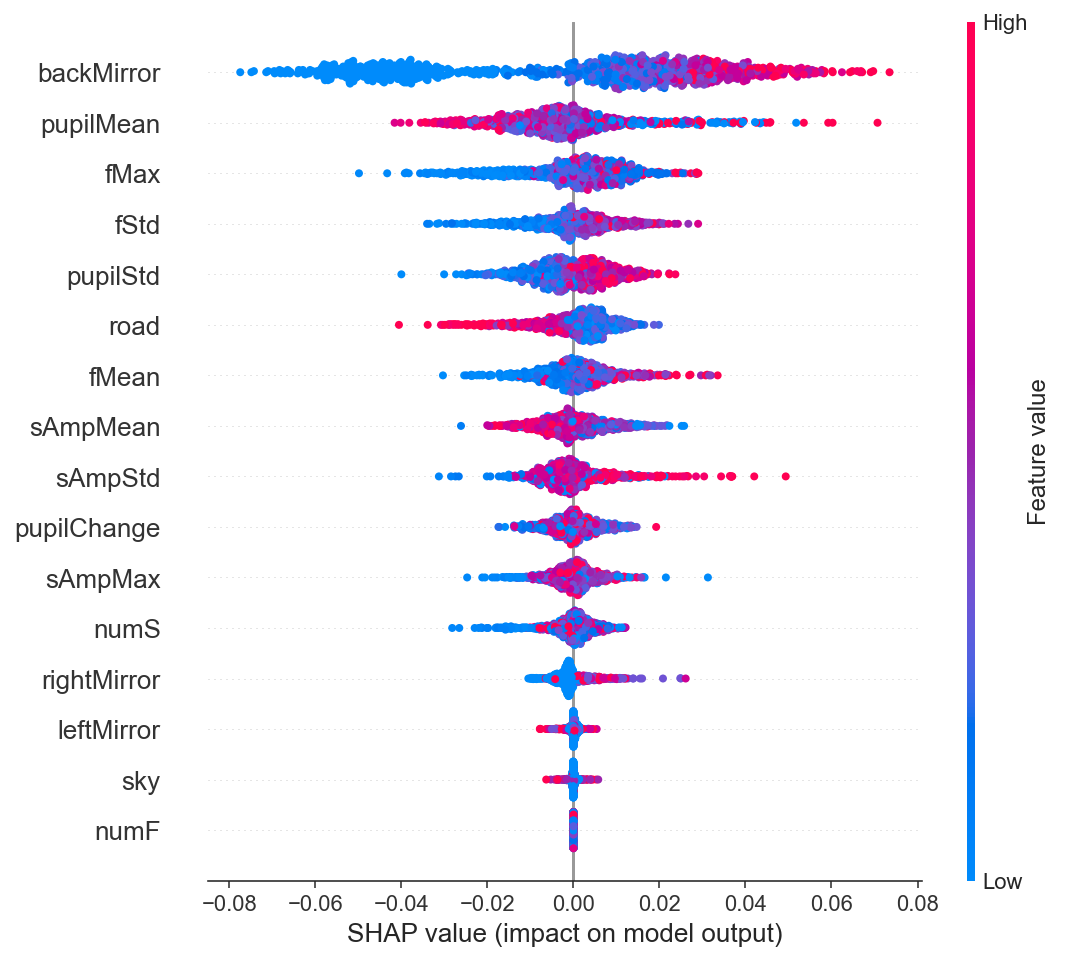

In [10]:
Xdata.columns = [
       'numS', 'sAmpMean', 'sAmpStd', 'sAmpMax', 'numF', 'fMean', 'fStd',
       'fMax', 'backMirror', 'leftMirror', 'rightMirror', 'road', 'sky',
       'pupilChange', 'pupilMean', 'pupilStd']
shap.initjs()
shap.summary_plot(SHAP, Xdata)

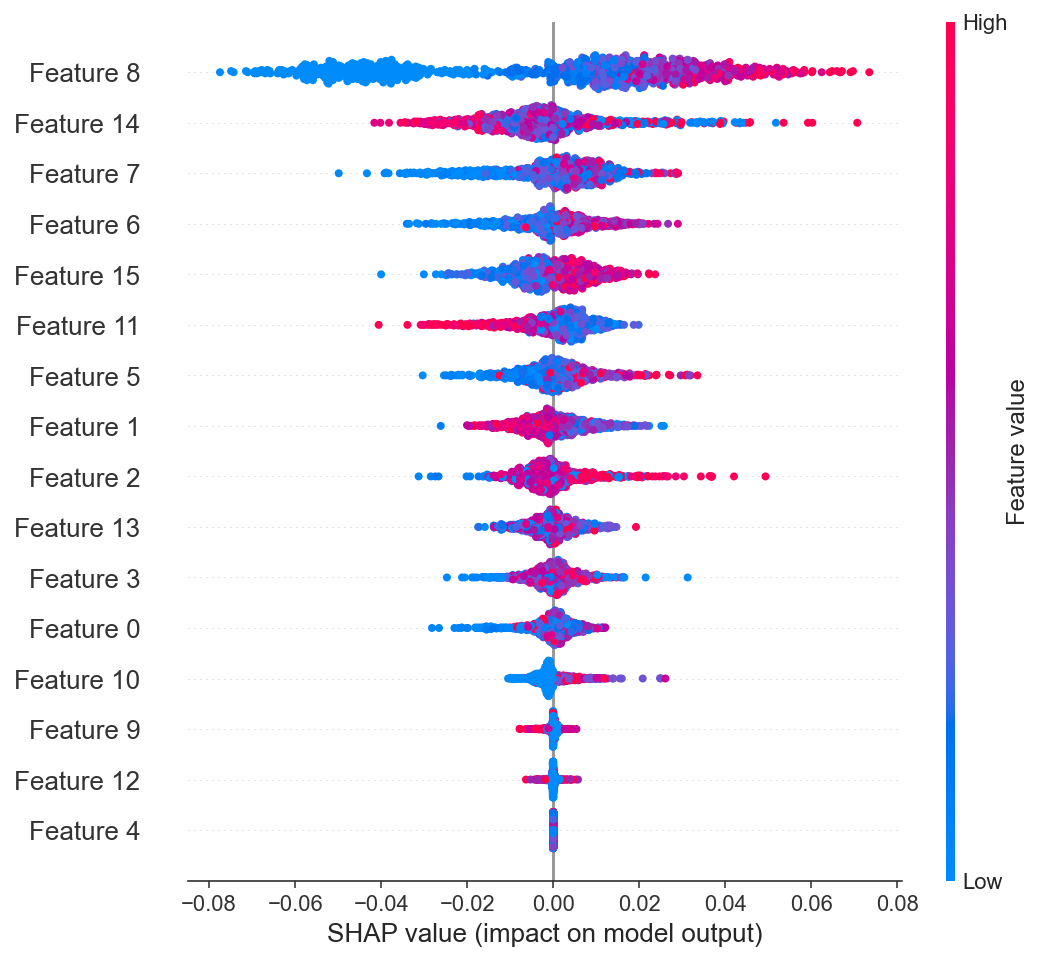

In [11]:
shap.summary_plot(SHAP, Y,max_display=16)

In [13]:
Ind = [8,14,7,6,15,11,5,1,2,13,3,0,10,9,12,4]

In [14]:
params = {
    'boosting_type': 'goss',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 100,
    'learning_rate': 0.05,
   # 'feature_fraction': 0.9,
   # 'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'feature_pre_filter': False
}
from datetime import datetime

X = np.array(Xall)
Y = np.array(yall)
Y = 1 - Y
rmseOverall = []
maeOverall = []
CorrOverall = []

rmseStdOverall = []
maeStdOverall = []
CorrStdOverall = []

shap_values = []
Xdata = [];
shap_interaction_values = [];
startTime = datetime.now()
count = 0;
                                                    
for k in range(len(Ind)):
    rmse = []
    mae = []
    Corr = []

    rmseStd = []
    maeStd = []
    CorrStd = []
    
    #k = 8
    num_i = k + 1

    X1 = X[:,Ind[0:k+1]]
    skf = KFold(n_splits=10, shuffle=True, random_state=0)
    for train_index, test_index in skf.split(X1,Y):
        X_train, X_test = X1[train_index], X1[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        Xdata.append(X_test)

        count = count + 1
        print(count)
        d_train = lgb.Dataset(X_train, y_train)
        d_valid = lgb.Dataset(X_test, y_test)


        model = lgb.train(params, d_train, 5000, valid_sets=[d_valid], verbose_eval=False, early_stopping_rounds=100)
        y_pred = model.predict(X_test)
            
        rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        mae.append(mean_absolute_error(y_test, y_pred))          
        Corr.append(np.corrcoef(y_test,y_pred))
        #explainer = shap.TreeExplainer(model, X_train)
        #shap_values.append(explainer.shap_values(X_test))
        #shap_interaction_values.append(explainer.shap_interaction_values(X_test))
        #shap_interaction_values.append(shap.TreeExplainer(model).shap_interaction_values(X_test))
        print(datetime.now()-startTime)
    

    rmseOverall.append(np.mean(rmse))
    rmseStdOverall.append(np.std(rmse))
    maeOverall.append(np.mean(mae))
    maeStdOverall.append(np.std(mae))
    CorrOverall.append(np.mean(Corr))
    CorrStdOverall.append(np.std(Corr))
    
    print(rmseOverall)
    print(rmseStdOverall)
    print(maeOverall)
    print(maeStdOverall)
    print(CorrOverall)
    print(CorrStdOverall)
    
    #break

    print(datetime.now()-startTime)
    


1
0:00:00.177124
2
0:00:00.205073
3
0:00:00.276722
4
0:00:00.372955
5
0:00:00.410101
6
0:00:00.460749
7
0:00:00.502019
8
0:00:00.542986
9
0:00:00.575990
10
0:00:00.614981
[0.1258947417137385]
[0.0076224642687062255]
[0.10142688814104675]
[0.006259434128539816]
[0.681085432620695]
[0.3238721293544065]
0:00:00.615702
11
0:00:00.732713
12
0:00:00.858971
13
0:00:00.898522
14
0:00:00.931497
15
0:00:00.968397
16
0:00:00.998203
17
0:00:01.059928
18
0:00:01.130444
19
0:00:01.159526
20
0:00:01.197727
[0.1258947417137385, 0.12413007689025453]
[0.0076224642687062255, 0.008709123843408172]
[0.10142688814104675, 0.09963410252685612]
[0.006259434128539816, 0.007333992241856028]
[0.681085432620695, 0.6951295880284958]
[0.3238721293544065, 0.31015281842056386]
0:00:01.198434
21
0:00:01.236777
22
0:00:01.303341
23
0:00:01.359558
24
0:00:01.395271
25
0:00:01.456321
26
0:00:01.503904
27
0:00:01.564699
28
0:00:01.603498
29
0:00:01.642768
30
0:00:01.742946
[0.1258947417137385, 0.12413007689025453, 0.123222

No handles with labels found to put in legend.


0.1211585944626589
8
0.09564561565189363
13
0.7187482604154313
8


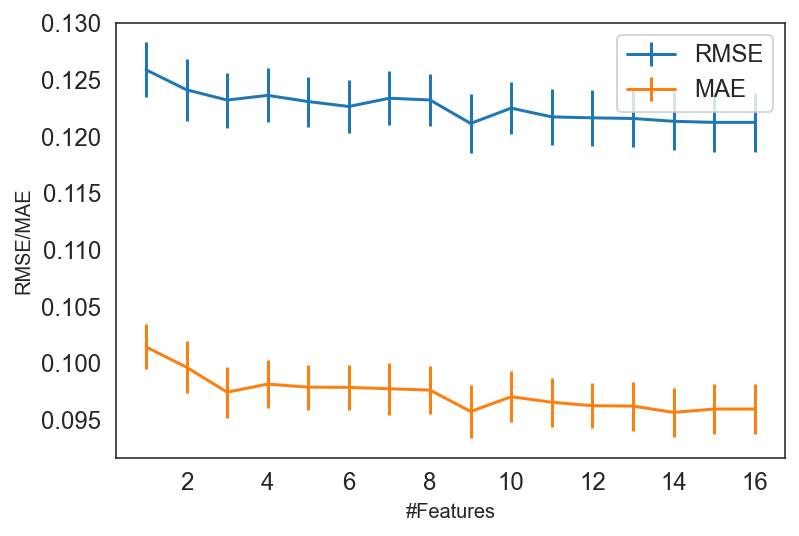

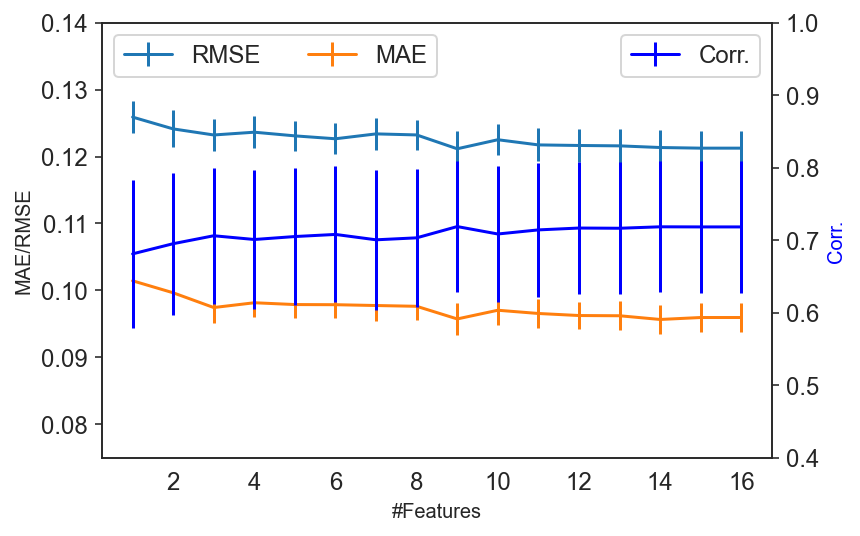

In [18]:
import matplotlib.pyplot as plt
import matplotlib

print(np.min(rmseOverall))
print(np.argmin(rmseOverall))
print(np.min(maeOverall))
print(np.argmin(maeOverall))
print(np.max(CorrOverall))
print(np.argmax(CorrOverall))
    

fig, ax = plt.subplots()
x = np.arange(len(Ind))+1
y = np.array(rmseOverall)
yerr = np.array(rmseStdOverall)/np.sqrt(10)
y1 = np.array(maeOverall)
yerr1 = np.array(maeStdOverall)/np.sqrt(10)
y2 = CorrOverall
yerr2 = np.array(CorrStdOverall)/np.sqrt(10)
#plt.figure(figsize=(10,10))
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
 
plt.errorbar(x, y , yerr=yerr,label='RMSE')
plt.errorbar(x, y1, yerr=yerr1,label='MAE')
ax.set_ylabel('RMSE/MAE')
ax.set_xlabel('#Features')
#plt.errorbar(x, y2, yerr=yerr2,label='Adj. R^2')
plt.rc('legend',fontsize=12)
plt.legend(loc='upper')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.errorbar(x, y , yerr=yerr,label='RMSE')
ax1.errorbar(x, y1, yerr=yerr1,label='MAE')
plt.rc('legend',fontsize=12)
plt.legend(loc='left')


ax2.errorbar(x, y2, yerr=yerr2,label='Corr.',color='b')
ax1.set_ylabel('MAE/RMSE')
ax1.set_ylim([0.075,.14])
ax2.set_ylabel('Corr.', color='b')
ax2.set_ylim([0.4,1])
ax1.set_xlabel('#Features')

ax1.legend(loc=2, ncol = len(ax1.lines))
ax2.legend(loc=1)
plt.rc('legend',fontsize=12)
#plt.legend(loc='upper')

In [20]:
params = {
    'boosting_type': 'goss',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 100,
    'learning_rate': 0.05,
   # 'feature_fraction': 0.9,
   # 'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'feature_pre_filter': False
}
from datetime import datetime

X = np.array(Xall)
Y = np.array(yall)
Y = 1 - Y
rmseOverall = []
maeOverall = []
CorrOverall = []

rmseStdOverall = []
maeStdOverall = []
CorrStdOverall = []

shap_values = []
Xdata = [];
shap_interaction_values = [];
startTime = datetime.now()
count = 0;
                                                    
for k in range(len(Ind)):
    rmse = []
    mae = []
    Corr = []

    rmseStd = []
    maeStd = []
    CorrStd = []
    
    k = 8
    num_i = k + 1

    X1 = X[:,Ind[0:k+1]]
    skf = KFold(n_splits=10, shuffle=True, random_state=0)
    for train_index, test_index in skf.split(X1,Y):
        X_train, X_test = X1[train_index], X1[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        Xdata.append(X_test)

        count = count + 1
        print(count)
        d_train = lgb.Dataset(X_train, y_train)
        d_valid = lgb.Dataset(X_test, y_test)


        model = lgb.train(params, d_train, 5000, valid_sets=[d_valid], verbose_eval=False, early_stopping_rounds=100)
        y_pred = model.predict(X_test)
            
        rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        mae.append(mean_absolute_error(y_test, y_pred))          
        Corr.append(np.corrcoef(y_test,y_pred))
        explainer = shap.TreeExplainer(model, X_train)
        shap_values.append(explainer.shap_values(X_test))
        shap_interaction_values.append(explainer.shap_interaction_values(X_test))
        print(datetime.now()-startTime)
    

    rmseOverall.append(np.mean(rmse))
    rmseStdOverall.append(np.std(rmse))
    maeOverall.append(np.mean(mae))
    maeStdOverall.append(np.std(mae))
    CorrOverall.append(np.mean(Corr))
    CorrStdOverall.append(np.std(Corr))
    
    print(rmseOverall)
    print(rmseStdOverall)
    print(maeOverall)
    print(maeStdOverall)
    print(CorrOverall)
    print(CorrStdOverall)
    
    break

    print(datetime.now()-startTime)
    


1
0:00:00.519974
2
0:00:01.070217
3
0:00:01.693909
4
0:00:02.194452
5
0:00:03.508060
6
0:00:03.869773
7
0:00:04.256355
8
0:00:04.749044
9
0:00:05.252024
10
0:00:05.695717
[0.1211585944626589]
[0.008327548656580001]
[0.09572527312640475]
[0.0073589681134667425]
[0.7187482604154313]
[0.2872609036225051]


In [21]:
Xdata = np.array(Xdata)
Xdata.shape
Y = np.concatenate((Xdata[0], Xdata[1],Xdata[2],Xdata[3],Xdata[4],Xdata[5],Xdata[6],Xdata[7],Xdata[8],Xdata[9]), axis=0)
Y.shape
shap_values = np.array(shap_values)
shap_values.shape
SHAP = np.concatenate((shap_values[0], shap_values[1],shap_values[2],shap_values[3],shap_values[4],shap_values[5],shap_values[6],shap_values[7],shap_values[8],shap_values[9]), axis=0)
SHAP.shape
Xdata = pd.DataFrame(Y) 

In [22]:
SHAPInteraction = np.concatenate((shap_interaction_values[0],shap_interaction_values[1],shap_interaction_values[2],
                                  shap_interaction_values[3],shap_interaction_values[4],shap_interaction_values[5],
                                  shap_interaction_values[6],shap_interaction_values[7],shap_interaction_values[8],
                                  shap_interaction_values[9]), axis=0)
SHAPInteraction.shape

(1060, 9, 9)

In [23]:
features = [
       'numS', 'sAmpMean', 'sAmpStd', 'sAmpMax', 'numF', 'fMean', 'fStd',
       'fMax', 'backMirror', 'leftMirror', 'rightMirror', 'road', 'sky',
       'pupilChange', 'pupilMean', 'pupilStd']

In [24]:
features = np.array(features)
print(features)

['numS' 'sAmpMean' 'sAmpStd' 'sAmpMax' 'numF' 'fMean' 'fStd' 'fMax'
 'backMirror' 'leftMirror' 'rightMirror' 'road' 'sky' 'pupilChange'
 'pupilMean' 'pupilStd']


In [25]:
features = features[Ind]

In [26]:
print(features)

['backMirror' 'pupilMean' 'fMax' 'fStd' 'pupilStd' 'road' 'fMean'
 'sAmpMean' 'sAmpStd' 'pupilChange' 'sAmpMax' 'numS' 'rightMirror'
 'leftMirror' 'sky' 'numF']


In [27]:
Xdata.columns = ['backMirror', 'pupilMean', 'fMax', 'fStd', 'pupilStd', 'road', 'fMean','sAmpMean', 'sAmpStd']

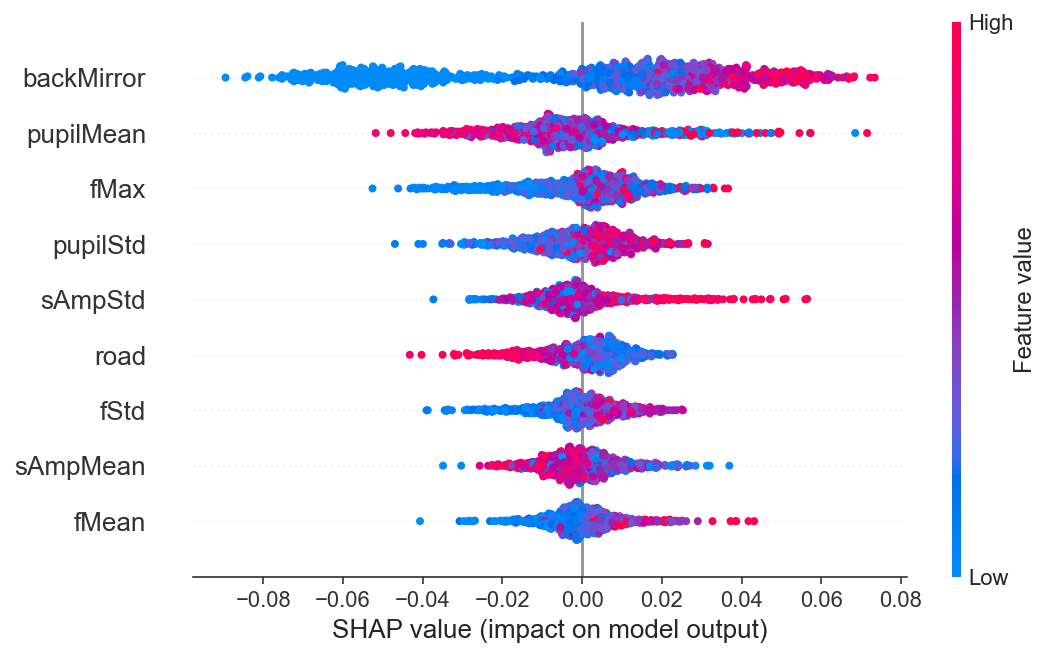

In [28]:
shap.initjs()
shap.summary_plot(SHAP, Xdata)

In [29]:
np.savetxt('Xdata1.csv', Xdata, delimiter=',')
np.savetxt('SHAPEye1.csv', SHAP, delimiter=',')

In [30]:
Xall,yall=df.iloc[:,:-1],df.iloc[:,-1]
X1 = Xall[['backMirror', 'pupilMean', 'fMax', 'fStd', 'pupilStd', 'road', 'fMean','sAmpMean', 'sAmpStd']]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X1)

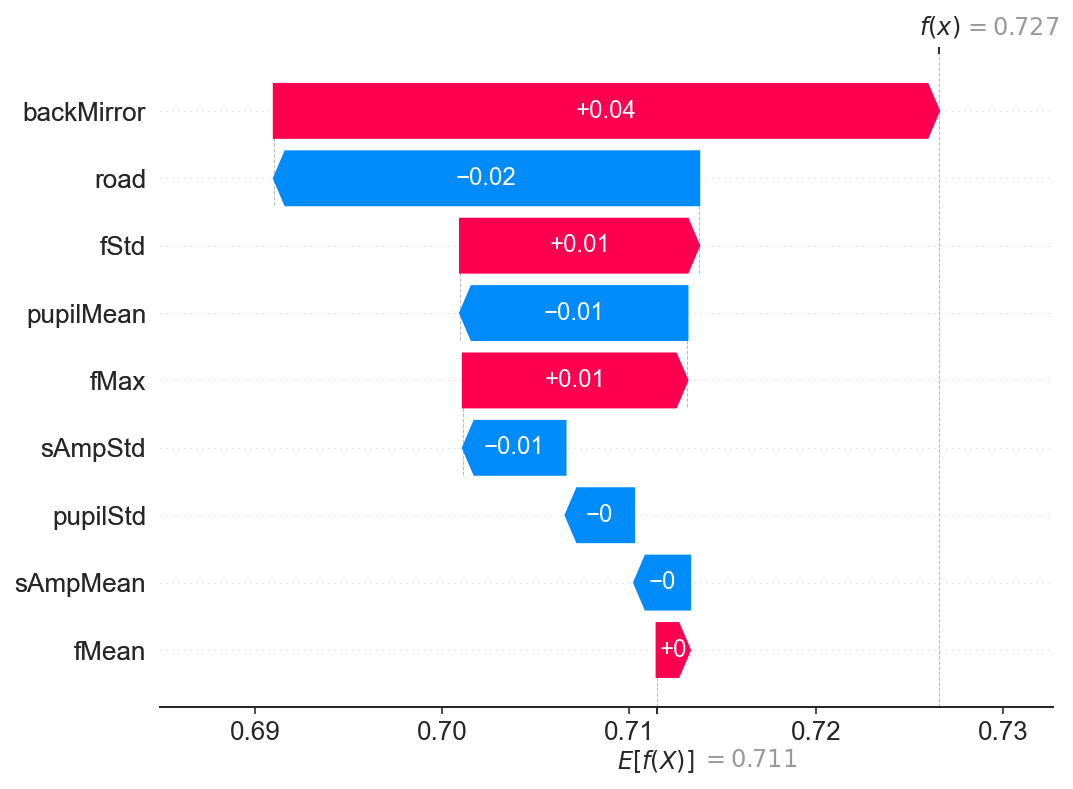

In [32]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[11], feature_names = Xdata.columns)

In [ ]:
X1